In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

# (1.) - initial version - step 20

In [2]:
#path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode/results_E-ether02-1mode-11010_scanopt_01_2023-07-01_14-14-11/'
#path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/G-scanopt-ether02-1mode-free/results_G-ether02-1mode-free-P-11010_scanopt_01_2023-07-08_02-04-49"
path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/H-scanopt-ether02-1mode/results_H-ether02-1mode-P-11010_scanopt_01_2023-07-09_01-56-22"

In [27]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

ref_id = 2
ivalue = 1640

lim0 = None
lim1 = None

C:\Users\micha\AppData\Local\Temp\ipykernel_47828\4220794966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_47828\4220794966.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


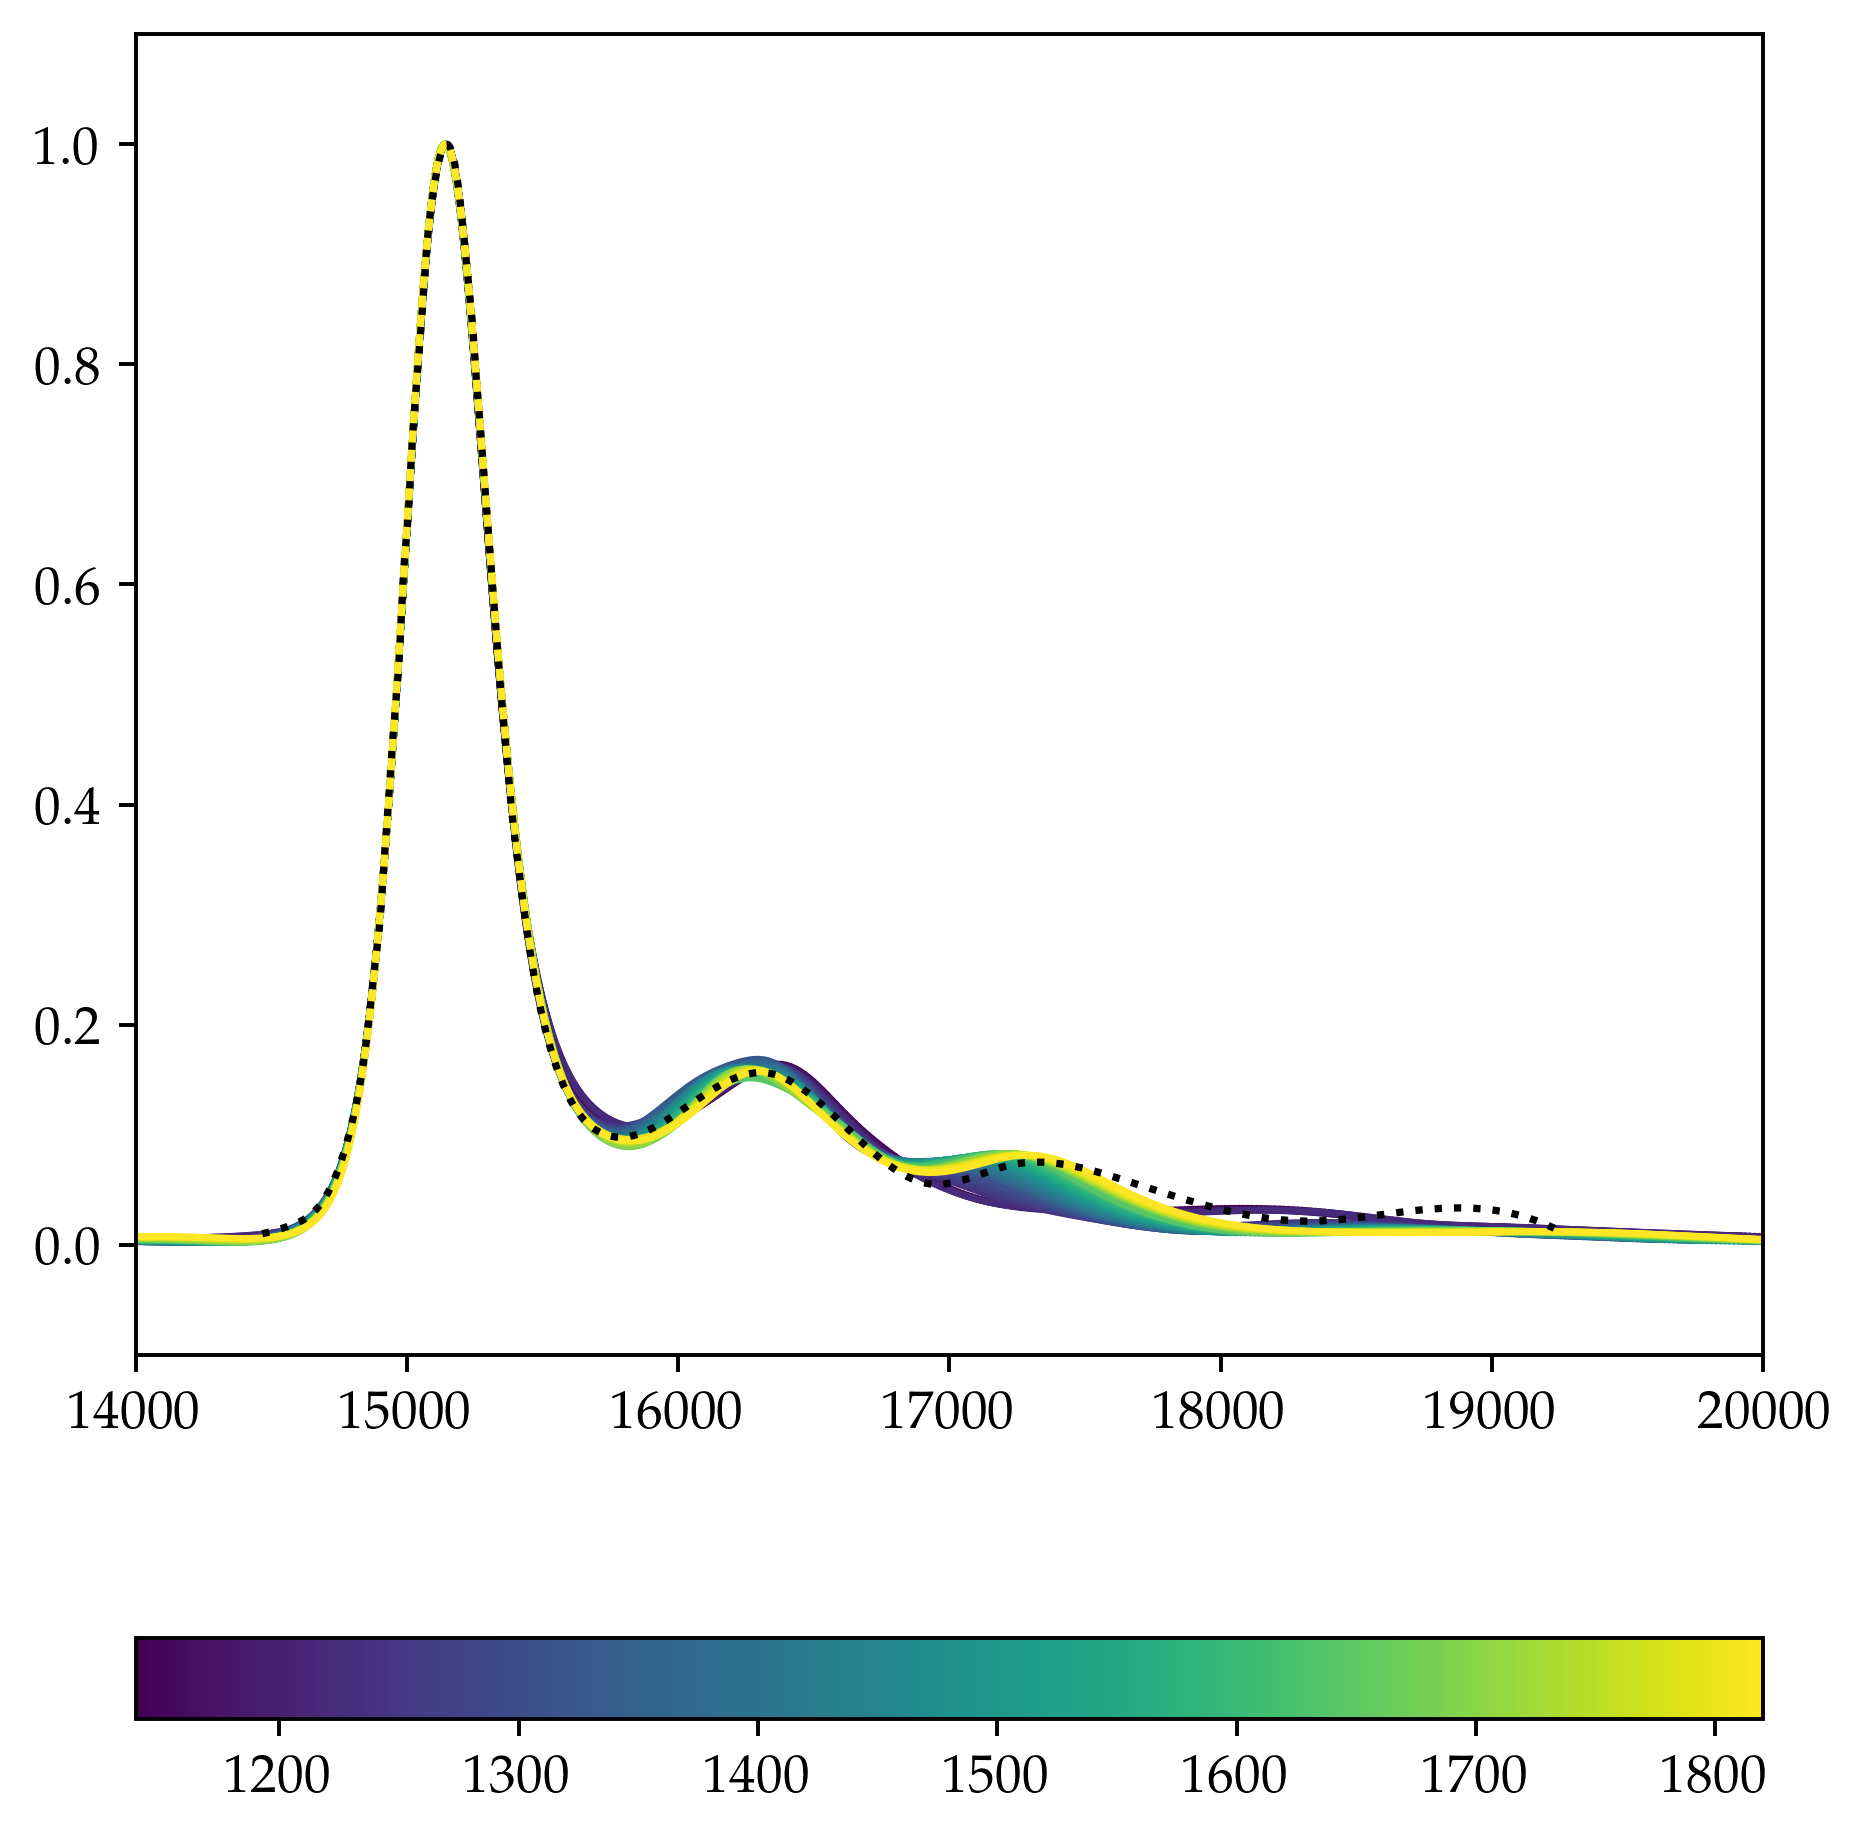

In [28]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(ref_id, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_47828\2528576996.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_47828\2528576996.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])


0.0454615224632


Text(0, 0.5, 'residuum')

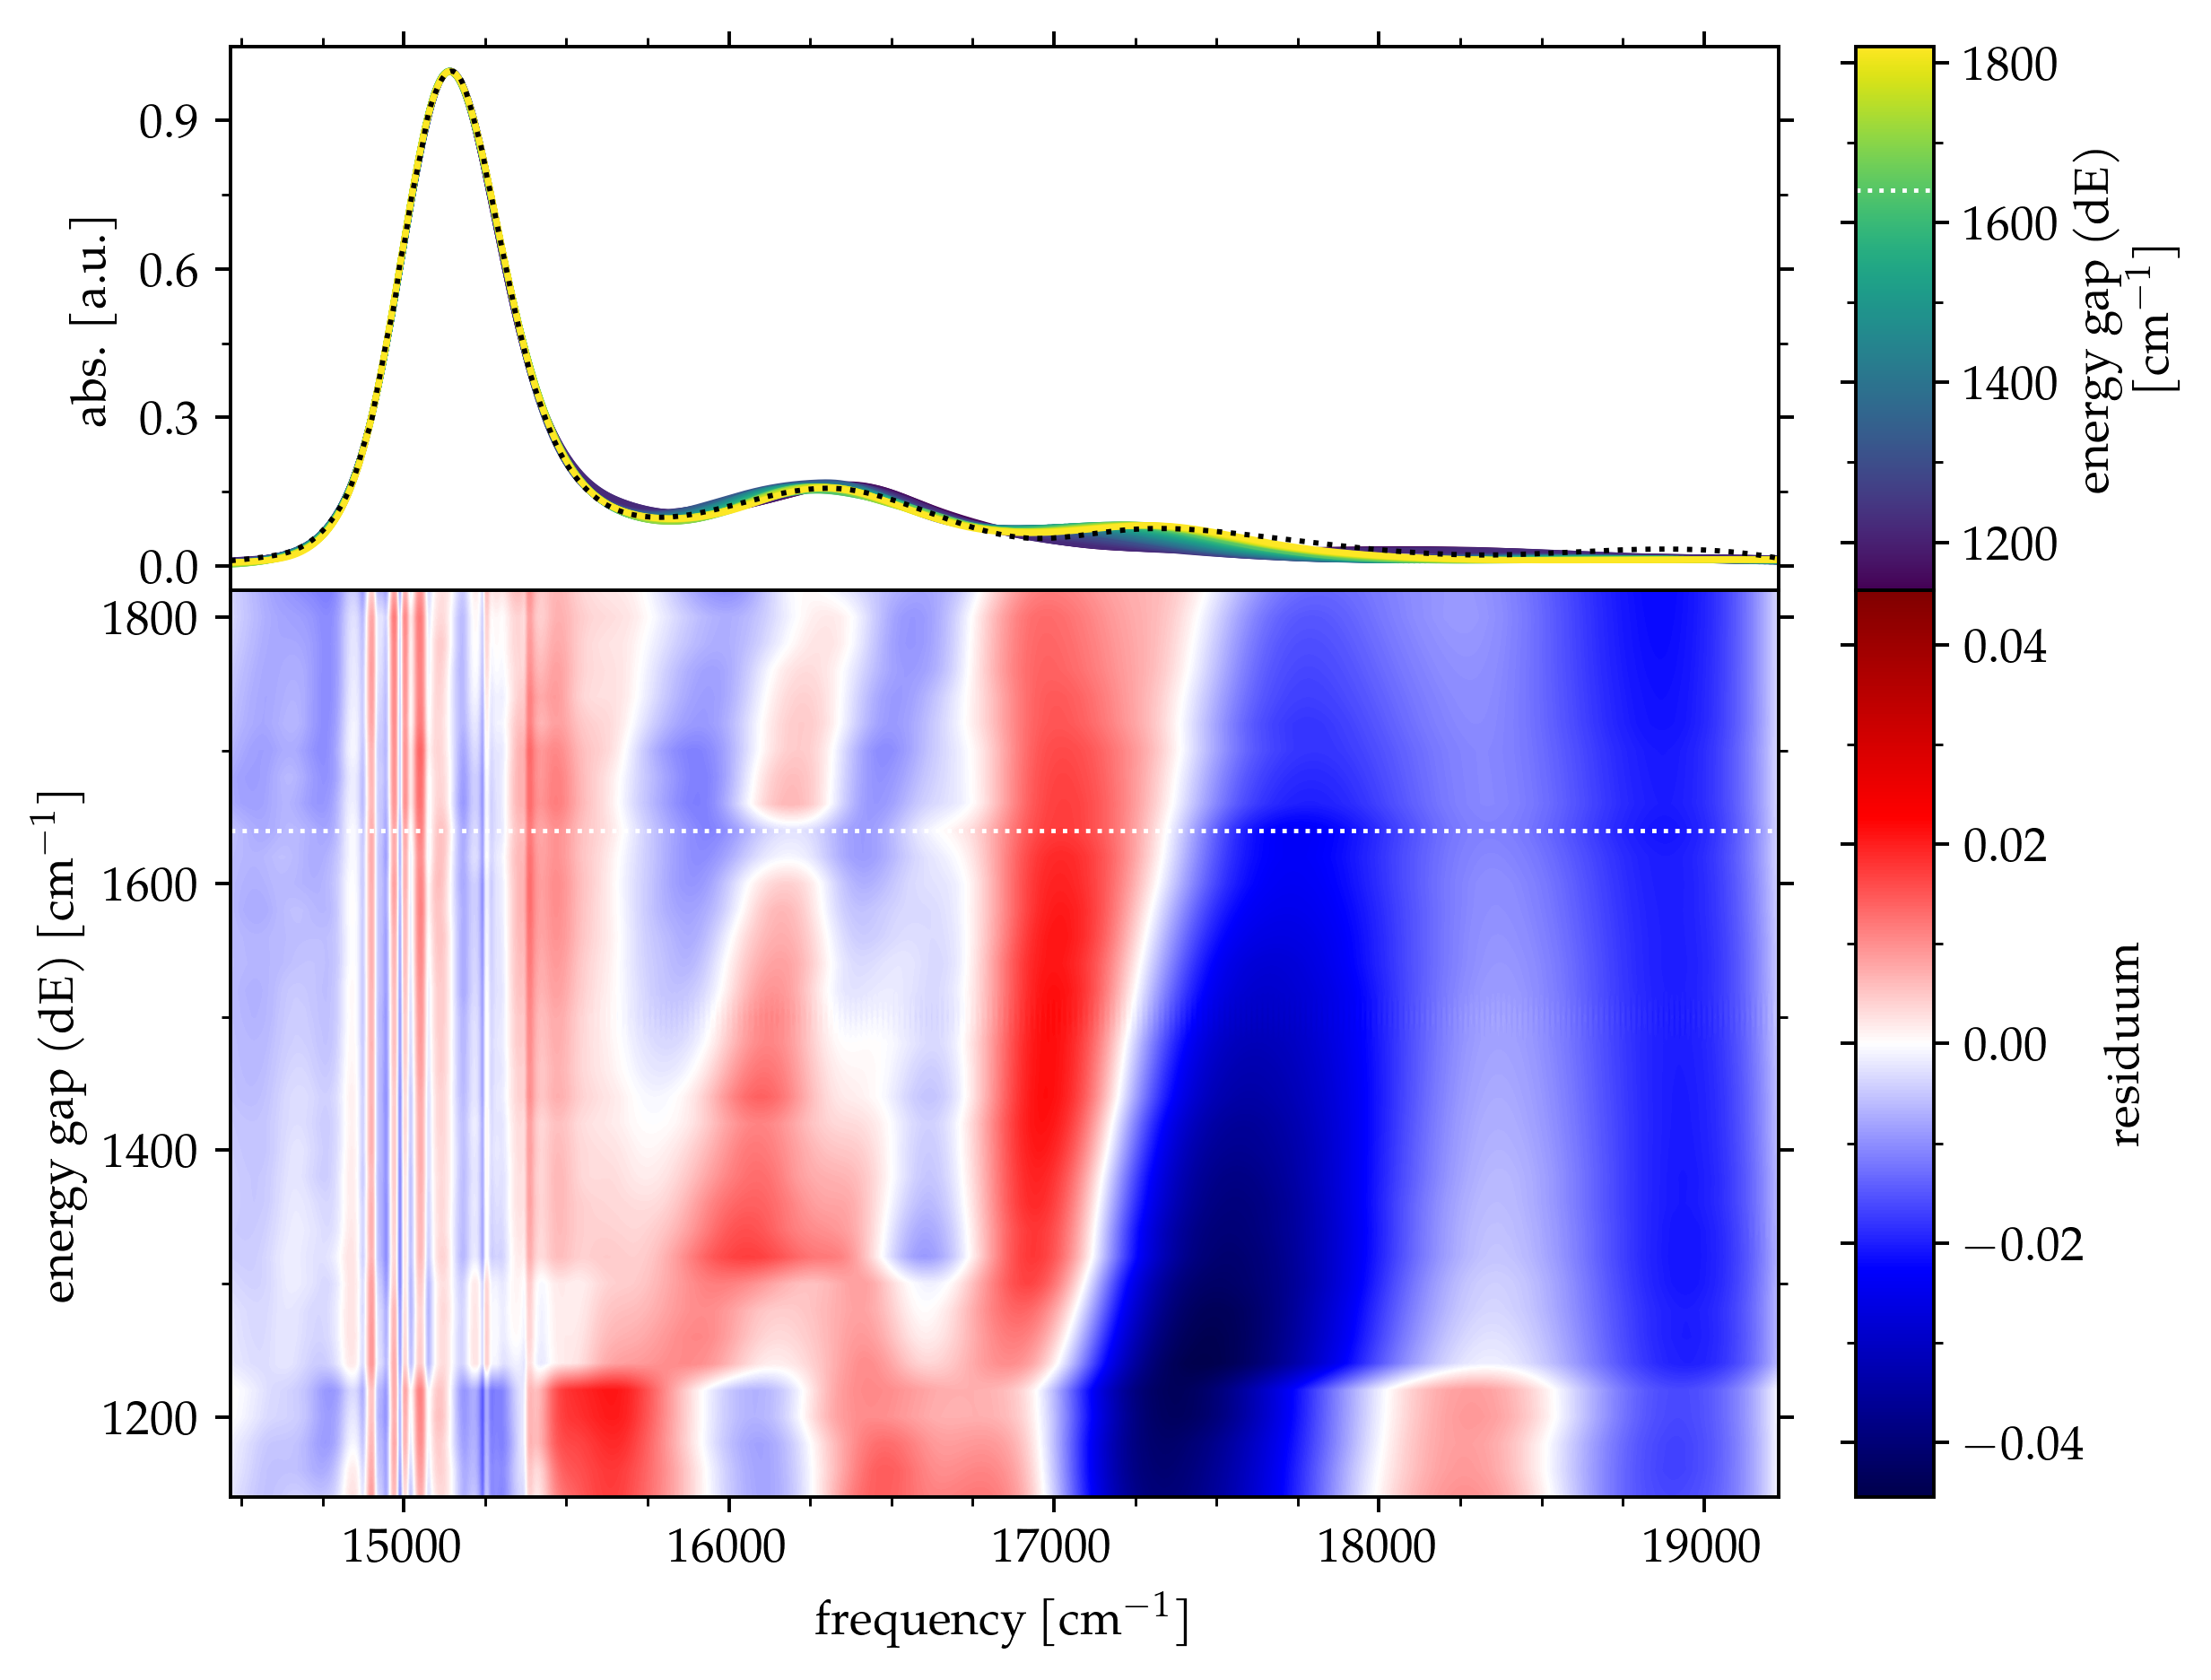

In [33]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)[:,lim0:lim1]

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax0.set_ylim(y[0,0], y[-1,0])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'energy gap (dE) [cm$^{-1}$]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering energy gap (dE) [cm$^{-1}$]}')
ax4.set_ylabel(r'residuum')

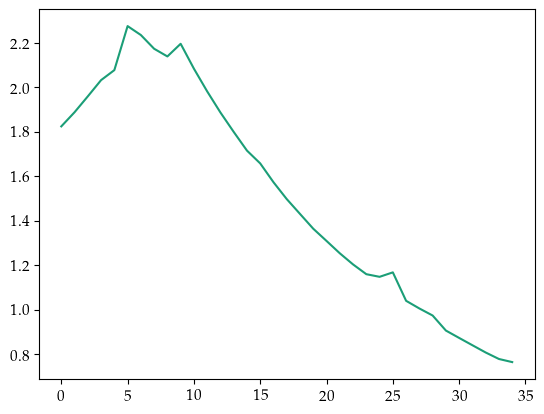

In [30]:
plt.plot((zax**2).sum(axis=1))

In [31]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_47828\2323635181.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'energy gap (dE) [cm$^{-1}$]')

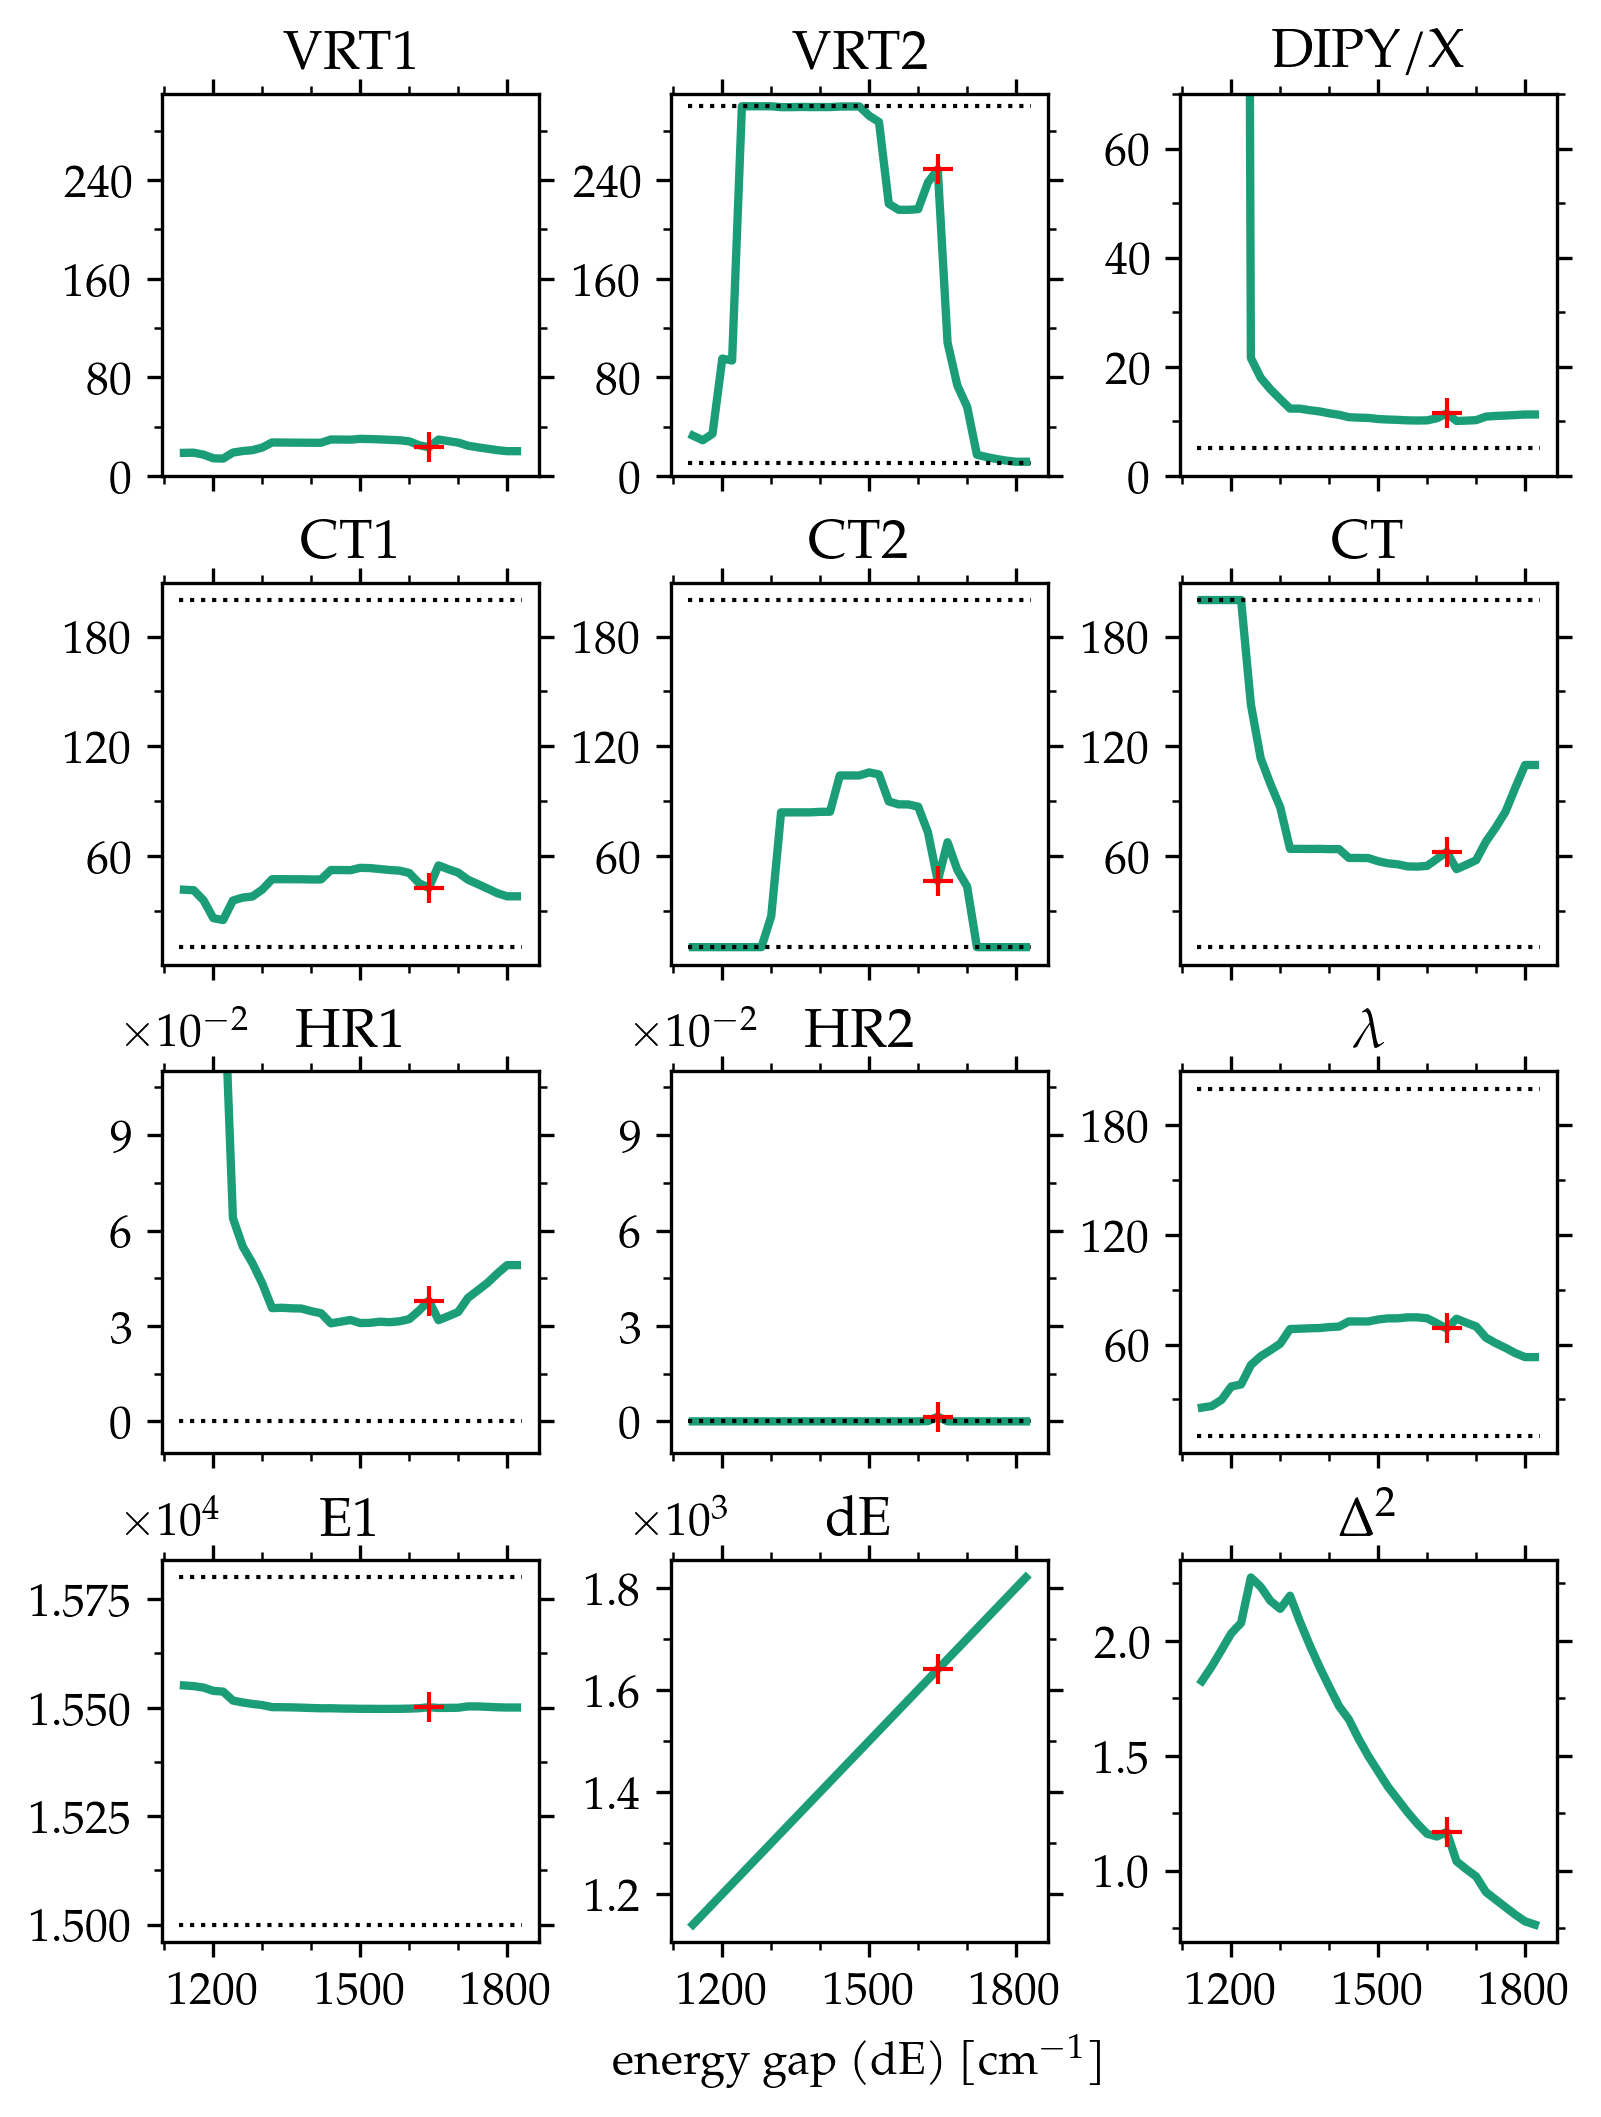

In [32]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[lim0:lim1]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == ivalue][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

# ## omega
# grid[3,1].plot(labels, om1, **pars)
# grid[3,1].plot(labels[ii], om1[ii], **mpars)
# grid[3,1].set_title('OM1')
# #draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

## dE
grid[3,1].plot(labels, de, **pars)
grid[3,1].plot(labels[ii], de[ii], **mpars)
grid[3,1].set_title('dE')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    

grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

#grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.11)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

#grid[0,0].set_xlim(10, 80)
grid[0,2].set_ylim(0,70)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(300))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(100))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('energy gap (dE) [cm$^{-1}$]')

# (2.) - finer step - step 5

In [2]:
path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/H-scanopt-ether02-1mode/results_H-ether02-1mode-s5-P-11010_scanopt_01_2023-07-10_10-19-08"

In [3]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

ref_id = 2
ivalue = 1640

lim0 = None
lim1 = None

C:\Users\micha\AppData\Local\Temp\ipykernel_37720\4220794966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Reorg: 1630.42135687
Reorg: 215.225855096
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.73s
Reorg: 1631.22735617
Reorg: 224.112133559
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.33s
Spectrum calculation (CPU): 7.21s
Reorg: 1630.96599842
Reorg: 244.248020619
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.43s
Reorg: 1632.18892798
Reorg: 245.432119192
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.32s
Spectrum calculation (CPU): 6.94s
Reorg: 1632.73397722
Reorg: 266.637930682
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 6.89s
Reorg: 1633.00774291
Reorg: 277.53583602
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.65s
Reorg: 1629.87472977
Reorg: 283.253088098
System init: 5.13s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.41s
Spectrum calculation (CPU): 7.56s
Reorg: 1634.3379006
Reorg: 294.311655874
System init: 5.31s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.35s
Spectrum calculation (CPU): 7.54s
Reorg: 1623.7032348
Reorg: 307.116612638
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.19s
Reorg: 1543.32698088
Reorg: 217.783005369
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.08s
Reorg: 1514.24362207
Reorg: 189.812084931
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.62s
Reorg: 1509.28613269
Reorg: 204.190412344
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.62s
Reorg: 1497.22178687
Reorg: 200.573965053
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.33s
Spectrum calculation (CPU): 7.13s
Reorg: 1460.3494395
Reorg: 163.781469731
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.38s
Reorg: 1393.19957891
Reorg: 114.428704422
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.68s
Reorg: 1336.38301993
Reorg: 65.0005222105
System init: 5.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.84s
Reorg: 1332.37747815
Reorg: 65.0063262385
System init: 6.72s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.86s
Spectrum calculation (CPU): 8.01s
Reorg: 1327.68733324
Reorg: 65.0185677812
System init: 6.39s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.76s
Spectrum calculation (CPU): 7.78s
Reorg: 1326.91066761
Reorg: 65.0240205678
System init: 6.16s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.60s
Spectrum calculation (CPU): 7.81s
Reorg: 1319.42281953
Reorg: 65.9648644915
System init: 6.45s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.65s
Spectrum calculation (CPU): 7.65s
Reorg: 1448.99721314
Reorg: 28.1819261342
System init: 6.31s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.64s
Spectrum calculation (CPU): 8.03s
Reorg: 1431.49555984
Reorg: 28.1819261392
System init: 6.22s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.66s
Spectrum calculation (CPU): 7.61s
Reorg: 1433.06315413
Reorg: 28.1819261344
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.62s
Spectrum calculation (CPU): 7.57s
Reorg: 1413.22282794
Reorg: 28.1819261392
System init: 6.08s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.55s
Spectrum calculation (CPU): 7.74s
Reorg: 1410.44603736
Reorg: 28.1819261343
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.63s
Spectrum calculation (CPU): 7.70s
Reorg: 1406.02211721
Reorg: 28.1819261354
System init: 5.71s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.64s
Spectrum calculation (CPU): 7.81s
Reorg: 1392.65674264
Reorg: 28.1819261343
System init: 6.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.56s
Spectrum calculation (CPU): 7.84s
Reorg: 1387.62850799
Reorg: 28.1819261392
System init: 6.30s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.48s
Spectrum calculation (CPU): 8.01s
Reorg: 1389.65257782
Reorg: 28.1819261342
System init: 5.52s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.40s
Spectrum calculation (CPU): 7.87s
Reorg: 1379.47626359
Reorg: 28.1819261343
System init: 6.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.60s
Spectrum calculation (CPU): 7.74s
Reorg: 1374.0080523
Reorg: 28.1819261342
System init: 5.52s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.42s
Reorg: 1370.54422361
Reorg: 28.181964035
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.33s
Reorg: 1367.6301751
Reorg: 28.1843049711
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.41s
Reorg: 1364.0538497
Reorg: 28.1990169241
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.11s
Reorg: 1366.35811161
Reorg: 105.682791071
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.01s
Reorg: 1365.93743494
Reorg: 106.396508259
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.02s
Reorg: 1363.33675076
Reorg: 107.019312896
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.06s
Reorg: 1362.03611209
Reorg: 114.262633735
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.09s
Reorg: 1358.40333451
Reorg: 119.718696994
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.23s
Reorg: 1354.74663089
Reorg: 124.316475732
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.36s
Reorg: 1350.48152654
Reorg: 130.069804883
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.38s
Spectrum calculation (CPU): 7.32s
Reorg: 1350.11283885
Reorg: 130.201852851
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.32s
Reorg: 1350.74573544
Reorg: 161.377513363
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.04s
Reorg: 1350.74573544
Reorg: 161.377513363
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.03s
Reorg: 1353.13037402
Reorg: 161.405875155
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.09s
Reorg: 1344.25640773
Reorg: 165.842325082
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.03s
Reorg: 1343.50971847
Reorg: 169.139046575
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.45s
Reorg: 1340.7224334
Reorg: 169.52761799
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 6.86s
Reorg: 1340.38527451
Reorg: 181.411065371
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.95s
Reorg: 1340.81459532
Reorg: 181.46960093
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.00s
Reorg: 1340.96998372
Reorg: 182.16074489
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.08s
Reorg: 1341.46268154
Reorg: 182.160955871
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.22s
Reorg: 1337.53895623
Reorg: 182.471669727
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.09s
Reorg: 1327.76523049
Reorg: 183.423365777
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.18s
Reorg: 1351.33113109
Reorg: 238.213996418
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 6.79s
Reorg: 1352.06618595
Reorg: 266.277785006
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.15s
Reorg: 1352.55139538
Reorg: 266.277029622
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.02s
Reorg: 1358.18623255
Reorg: 265.391650462
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.13s
Reorg: 1358.63900341
Reorg: 265.346233906
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.95s
Reorg: 1357.39214264
Reorg: 265.634092607
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.17s
Reorg: 1353.02728764
Reorg: 270.592983393
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.54s
Reorg: 1356.84457727
Reorg: 272.604722356
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 6.95s
Reorg: 1355.72300176
Reorg: 271.80531886
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.05s
Reorg: 1355.55524706
Reorg: 273.669166267
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.12s
Reorg: 1356.82722456
Reorg: 272.454243073
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 6.97s
Reorg: 1352.67658346
Reorg: 285.223574308
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.48s
Reorg: 1354.22325311
Reorg: 285.656931635
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.00s
Reorg: 1355.96470695
Reorg: 285.739098579
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.25s
Reorg: 1354.8174797
Reorg: 285.137046434
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.91s
Reorg: 1354.3678749
Reorg: 285.04821055
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.94s
Reorg: 1357.58923382
Reorg: 285.085674611
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.18s
Reorg: 1354.24362436
Reorg: 285.120545581
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.58s
Reorg: 1351.27387659
Reorg: 286.533024247
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.13s
Reorg: 1353.95846598
Reorg: 286.451819468
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.08s
Reorg: 1355.34659305
Reorg: 286.7899009
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.11s
Reorg: 1355.34659305
Reorg: 286.7899009
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.23s
Reorg: 1356.03652117
Reorg: 286.788019872
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 6.96s
Reorg: 1357.21969175
Reorg: 286.92865624
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.26s
Reorg: 1357.92806327
Reorg: 289.121254982
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 6.98s
Reorg: 1359.43476812
Reorg: 289.518303854
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 7.12s
Reorg: 1360.61901861
Reorg: 289.518911948
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.14s
Reorg: 1361.64962216
Reorg: 289.217557913
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.15s
Reorg: 1363.41411169
Reorg: 289.052638069
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.23s
Reorg: 1365.46497865
Reorg: 291.539118625
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.79s
Reorg: 1366.08222898
Reorg: 291.867289389
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.24s
Reorg: 1368.11971874
Reorg: 306.284606692
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.28s
Reorg: 1367.39954139
Reorg: 326.523496928
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.21s
Reorg: 1367.51069401
Reorg: 326.736608708
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.27s
Reorg: 1371.54708389
Reorg: 326.112131785
System init: 5.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.99s
Reorg: 1373.10262595
Reorg: 327.585040242
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.94s
Reorg: 1374.62369755
Reorg: 336.652397138
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 7.02s
Reorg: 1375.41596398
Reorg: 338.701816136
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 6.95s
Reorg: 1380.31228038
Reorg: 340.222026666
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.18s
Reorg: 1380.32726668
Reorg: 340.225312663
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.29s
Reorg: 1384.17119747
Reorg: 341.185389494
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.05s
Reorg: 1383.928669
Reorg: 364.987176693
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.34s
Reorg: 1390.41059721
Reorg: 366.997357671
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.37s
Reorg: 1390.41059721
Reorg: 366.997357671
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.03s
Reorg: 1393.77031697
Reorg: 398.661612882
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.55s
Reorg: 1391.36061228
Reorg: 422.332935412
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.19s
Reorg: 1388.5053068
Reorg: 140.338572424
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.10s
Reorg: 1395.06204833
Reorg: 412.232649306
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.26s
Reorg: 1396.36152806
Reorg: 423.575106396
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.23s
Reorg: 1403.77717877
Reorg: 427.470969191
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.49s
Reorg: 1394.91124149
Reorg: 476.458021341
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.15s
Reorg: 1409.12822118
Reorg: 453.304620725
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.10s
Reorg: 1405.03742953
Reorg: 479.525462221
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.05s
Reorg: 1407.92986346
Reorg: 482.346022285
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.20s
Reorg: 1412.58554829
Reorg: 534.753753328
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.04s
Reorg: 1412.63323411
Reorg: 534.754404701
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.37s
Spectrum calculation (CPU): 7.02s
Reorg: 1417.12252428
Reorg: 560.307769278
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.36s
Reorg: 1423.62550744
Reorg: 554.522965366
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.31s
Spectrum calculation (CPU): 7.07s
Reorg: 1423.57753362
Reorg: 554.647687742
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 6.95s
Reorg: 1414.1762166
Reorg: 613.406288885
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.40s
Reorg: 1445.52411263
Reorg: 473.823625499
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.07s
Reorg: 1450.34566122
Reorg: 474.208078516
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.81s
Reorg: 1450.80685681
Reorg: 495.789846352
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.35s
Reorg: 1452.57074671
Reorg: 507.665346349
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.15s
Reorg: 1453.25209706
Reorg: 525.523820904
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.41s
Reorg: 1453.3750675
Reorg: 542.414676478
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.29s
Reorg: 1455.31750051
Reorg: 557.58556953
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.32s
Spectrum calculation (CPU): 6.98s
Reorg: 1454.67845383
Reorg: 570.4827321
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.04s
Reorg: 1452.99378821
Reorg: 587.421195463
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 6.98s
Reorg: 1448.48035116
Reorg: 605.459459838
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.34s
Reorg: 1448.52067523
Reorg: 620.752728009
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.30s
Reorg: 1447.28332067
Reorg: 636.006385559
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.07s
Reorg: 1447.34354185
Reorg: 651.414153827
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.85s
Reorg: 1443.90362719
Reorg: 667.399959719
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 6.99s
Reorg: 1439.32282733
Reorg: 686.890341604
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 6.98s
Reorg: 1447.46188123
Reorg: 697.434075286
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.22s
Reorg: 1445.99747153
Reorg: 718.634419436
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.87s
Reorg: 1431.16630411
Reorg: 730.345833212
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.04s
Reorg: 1434.58763208
Reorg: 743.595440154
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.17s
Reorg: 1433.48910171
Reorg: 750.716244288
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.13s
Reorg: 1413.10796915
Reorg: 781.780342356
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.10s
Reorg: 1408.61648615
Reorg: 796.312831721
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.87s
Reorg: 1389.94468462
Reorg: 818.508205568
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.11s
Reorg: 1360.24166772
Reorg: 842.540564353
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 6.86s
Reorg: 1289.31532698
Reorg: 845.457784027
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.88s
Reorg: 1273.70606315
Reorg: 845.457784027
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.21s
Spectrum calculation (CPU): 7.01s
Reorg: 1245.81826627
Reorg: 845.457784027
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.03s
Reorg: 759.959386602
Reorg: 208.947173244
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 6.88s
Reorg: 748.310880305
Reorg: 141.809031483
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.13s
Reorg: 747.470541337
Reorg: 154.611972266
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 6.96s
Reorg: 736.702546151
Reorg: 340.223263143
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.06s
Reorg: 732.23187823
Reorg: 370.748355056
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.20s
Spectrum calculation (CPU): 6.95s
Reorg: 735.4813772
Reorg: 379.216402716
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 7.06s
Reorg: 738.759207356
Reorg: 392.89964267
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.85s
Reorg: 738.870191758
Reorg: 392.899664304
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.25s
Reorg: 738.956965242
Reorg: 400.696162662
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.09s
Reorg: 739.79773673
Reorg: 410.022815434
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.21s
Spectrum calculation (CPU): 7.32s
Reorg: 735.831964534
Reorg: 496.485580906
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 6.90s
Reorg: 736.152202147
Reorg: 496.485674601
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.5s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 6.73s
Reorg: 742.14646953
Reorg: 529.763072698
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.06s
Reorg: 745.972599207
Reorg: 588.555771601
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.10s
Reorg: 745.654420439
Reorg: 627.573720837
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.99s
Reorg: 751.105689121
Reorg: 679.146649282
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.21s
Spectrum calculation (CPU): 7.41s
Reorg: 747.843495617
Reorg: 677.928829581
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.09s
Reorg: 751.668847542
Reorg: 725.369801986
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.14s
Reorg: 756.495280986
Reorg: 791.156394165
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 6.89s
Reorg: 760.981045513
Reorg: 847.308469066
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.02s
Reorg: 760.652957077
Reorg: 848.357918725
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.31s
Reorg: 764.383231616
Reorg: 851.962212184
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.04s
Reorg: 764.897419338
Reorg: 853.930075393
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 6.88s
Reorg: 764.897421273
Reorg: 853.930075392
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.20s
Spectrum calculation (CPU): 7.29s
Reorg: 764.897421273
Reorg: 853.930075392
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.28s
Reorg: 765.011626608
Reorg: 853.926923667
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.08s
Reorg: 773.979242306
Reorg: 858.379576783
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 6.95s
Reorg: 777.749071871
Reorg: 858.92287096
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.21s
Spectrum calculation (CPU): 7.16s
Reorg: 780.619751276
Reorg: 858.643094407
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.21s
Reorg: 784.126878851
Reorg: 859.570496739
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.16s
Reorg: 788.41431123
Reorg: 860.529294649
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.01s
Reorg: 793.114381166
Reorg: 861.84464027
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.21s
Spectrum calculation (CPU): 7.12s
Reorg: 798.286147908
Reorg: 860.746808204
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 6.98s
Reorg: 797.217754638
Reorg: 858.925190925
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.10s
Reorg: 797.399077572
Reorg: 858.91906213
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.00s
Reorg: 801.88355405
Reorg: 857.822432416
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.18s
Reorg: 804.653471224
Reorg: 857.36709564
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.10s
Reorg: 808.744248838
Reorg: 856.604249614
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.40s
Reorg: 811.176601212
Reorg: 856.505747868
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.95s
Reorg: 814.744832844
Reorg: 855.742150794
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.37s
Reorg: 817.438783868
Reorg: 855.527914242
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.07s
Reorg: 822.630594904
Reorg: 854.591690733
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.88s
Reorg: 820.751684374
Reorg: 851.22538048
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.41s
Reorg: 824.719910933
Reorg: 850.516406463
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.42s
Reorg: 824.015358663
Reorg: 846.880080241
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.27s
Reorg: 835.01131375
Reorg: 851.774337797
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.96s
Reorg: 836.505127595
Reorg: 851.42563636
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 6.90s
Reorg: 856.461015903
Reorg: 859.782000371
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 7.35s
Reorg: 852.963061735
Reorg: 859.611427328
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.22s
Spectrum calculation (CPU): 7.01s
Reorg: 857.997335571
Reorg: 858.348954703
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 6.94s
Reorg: 866.725018406
Reorg: 872.604333812
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.21s
Spectrum calculation (CPU): 7.22s
Reorg: 870.419717847
Reorg: 871.655982756
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 6.92s
Reorg: 873.905419828
Reorg: 870.798502991
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.01s
Reorg: 876.747208168
Reorg: 869.714443946
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.15s
Reorg: 880.570894542
Reorg: 868.613675088
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.23s
Spectrum calculation (CPU): 6.93s
Reorg: 883.374404397
Reorg: 867.880807747
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.26s
Reorg: 891.610476251
Reorg: 866.337951387
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.06s
Reorg: 891.610476251
Reorg: 866.337951387
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.22s
Reorg: 894.206768875
Reorg: 864.154899182
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.16s
Reorg: 894.965890999
Reorg: 864.12302277
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished
C:\Users\micha\AppData\Local\Temp\ipykernel_37720\4220794966.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


Tensor calculation: 2.26s
Spectrum calculation (CPU): 6.88s


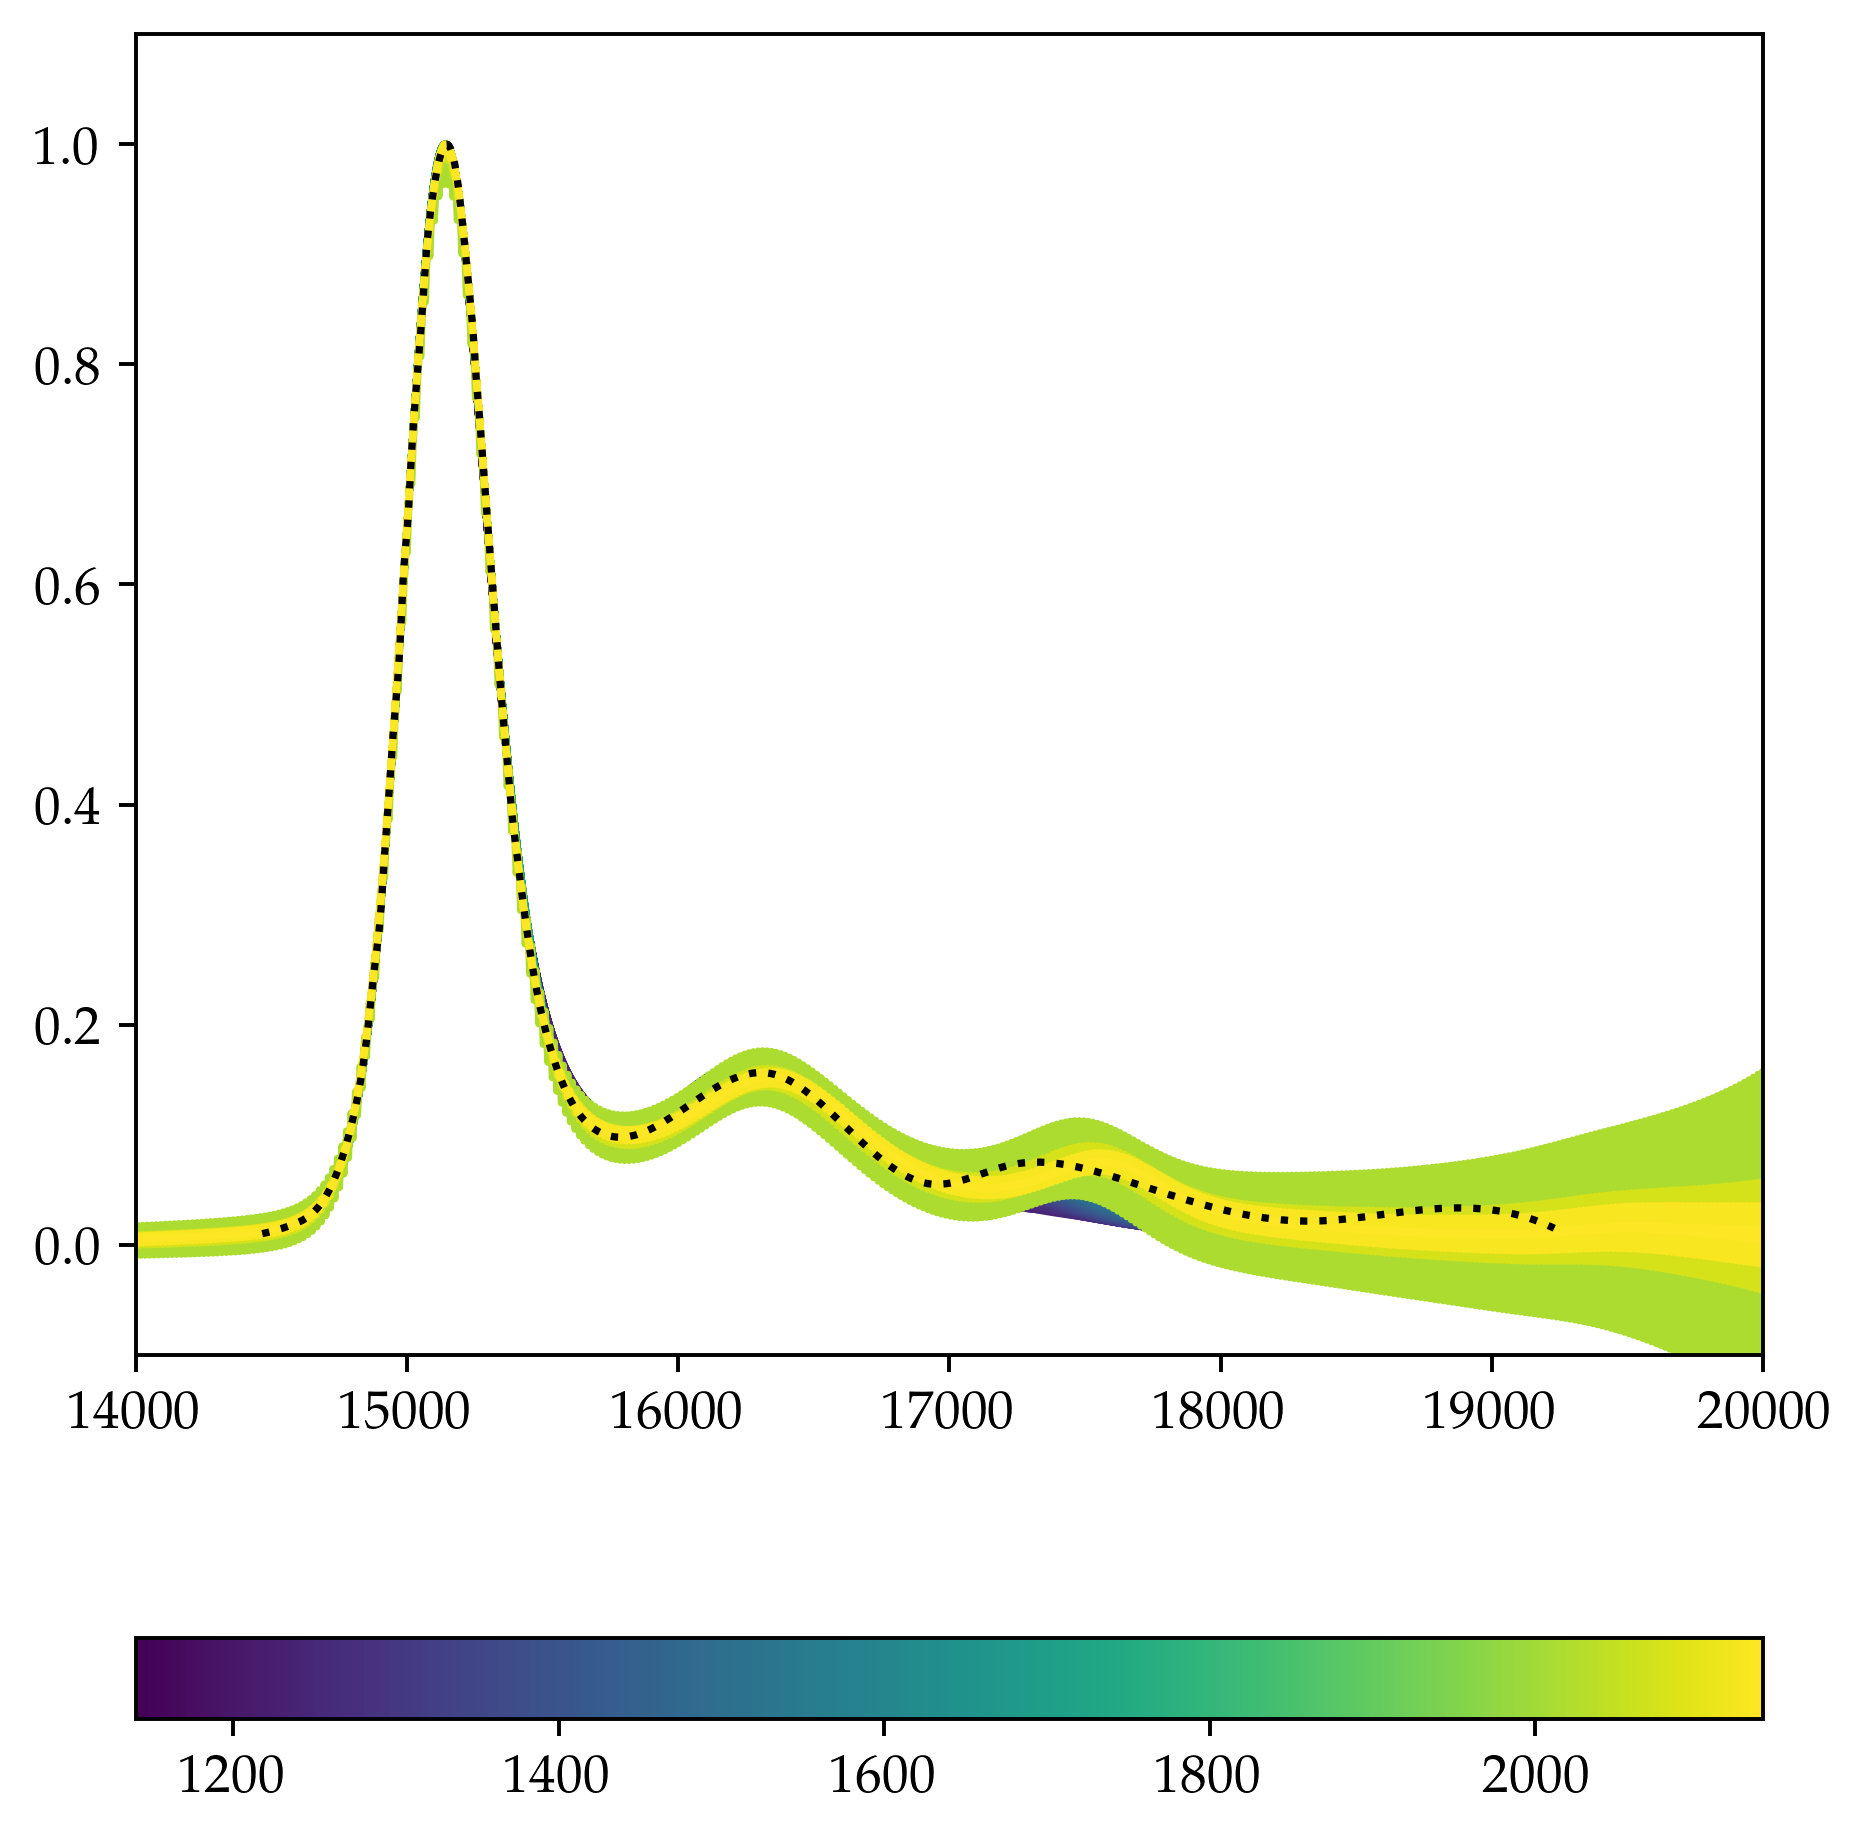

In [4]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(ref_id, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_37720\2528576996.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_37720\2528576996.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])
 83%|████████████████████████████████████████████████████████████████████▌              | 166/201 [00:42<00:28,  1.23it/s]C:\Users\micha\miniconda3\envs\py310-maya-1\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation 

0.0458422099621


Text(0, 0.5, 'residuum')

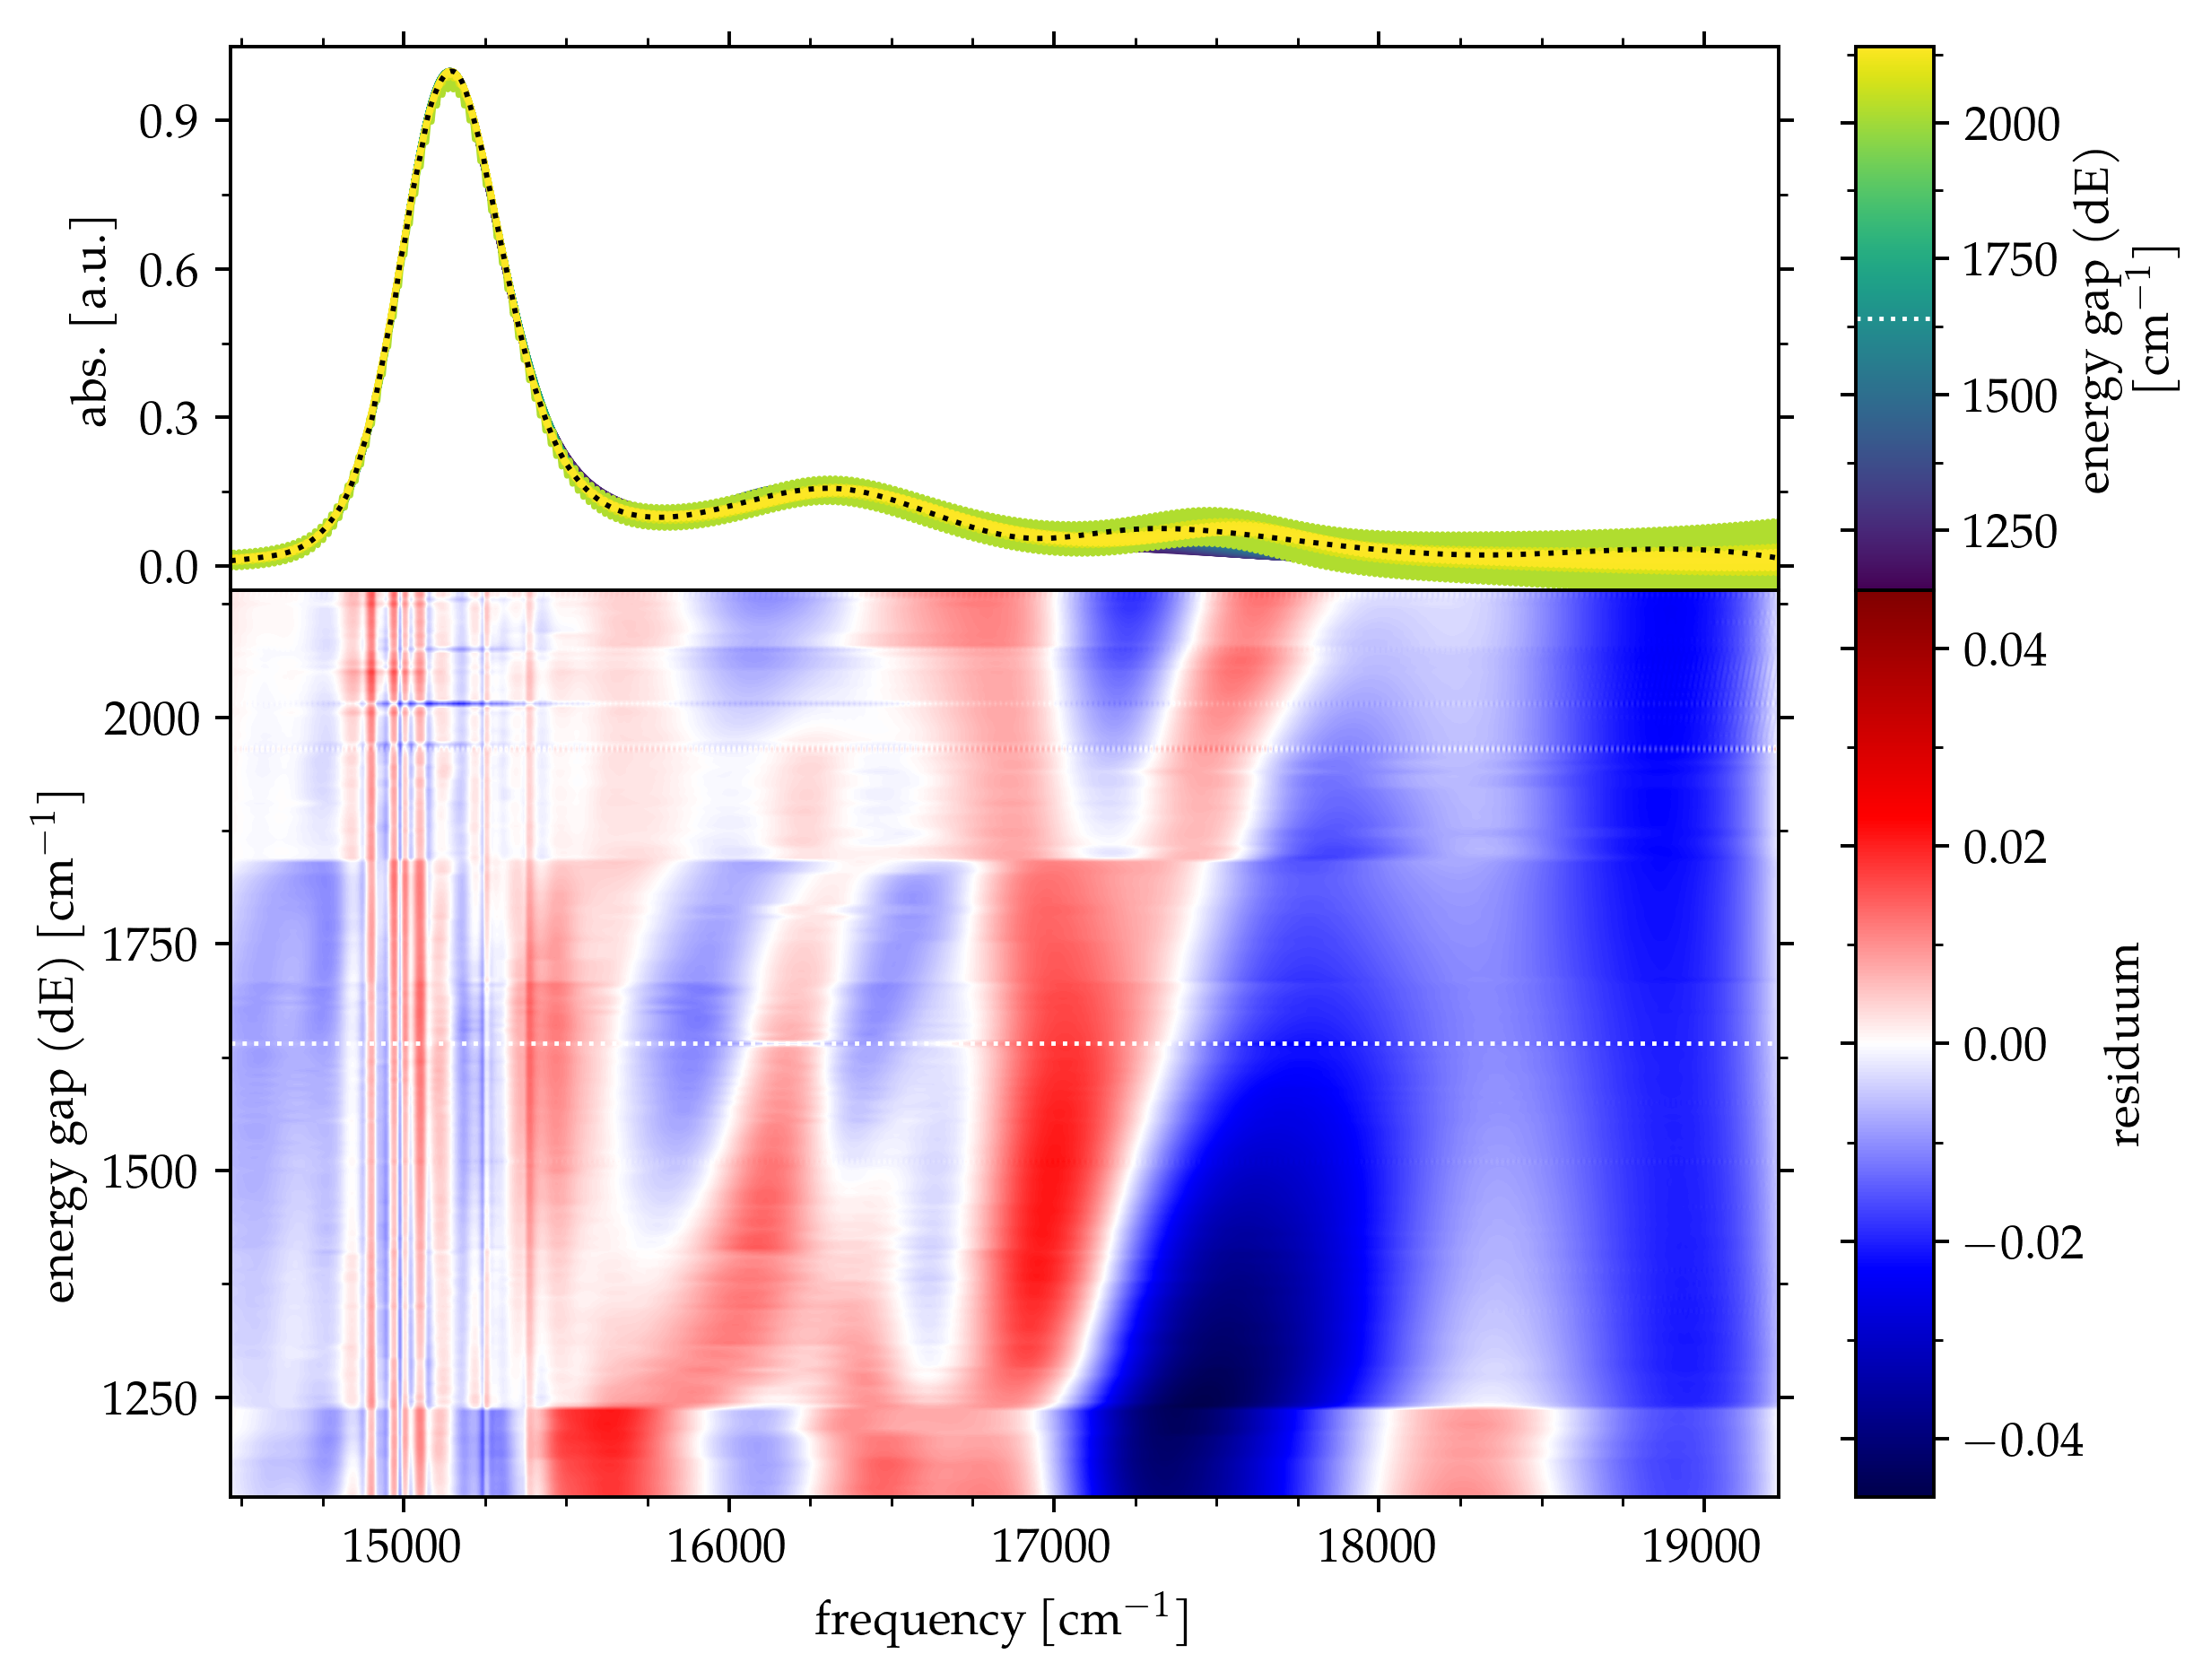

In [5]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)[:,lim0:lim1]

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax0.set_ylim(y[0,0], y[-1,0])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'energy gap (dE) [cm$^{-1}$]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering energy gap (dE) [cm$^{-1}$]}')
ax4.set_ylabel(r'residuum')

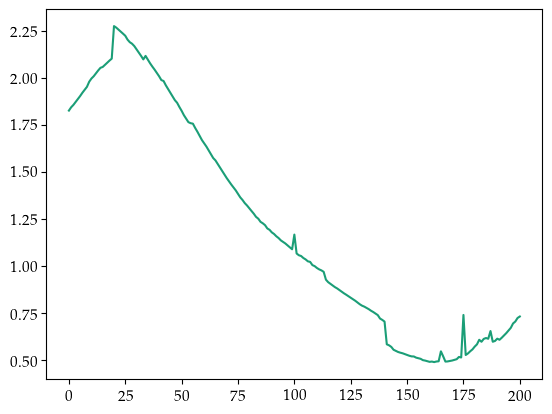

In [6]:
plt.plot((zax**2).sum(axis=1))

In [7]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_37720\2323635181.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'energy gap (dE) [cm$^{-1}$]')

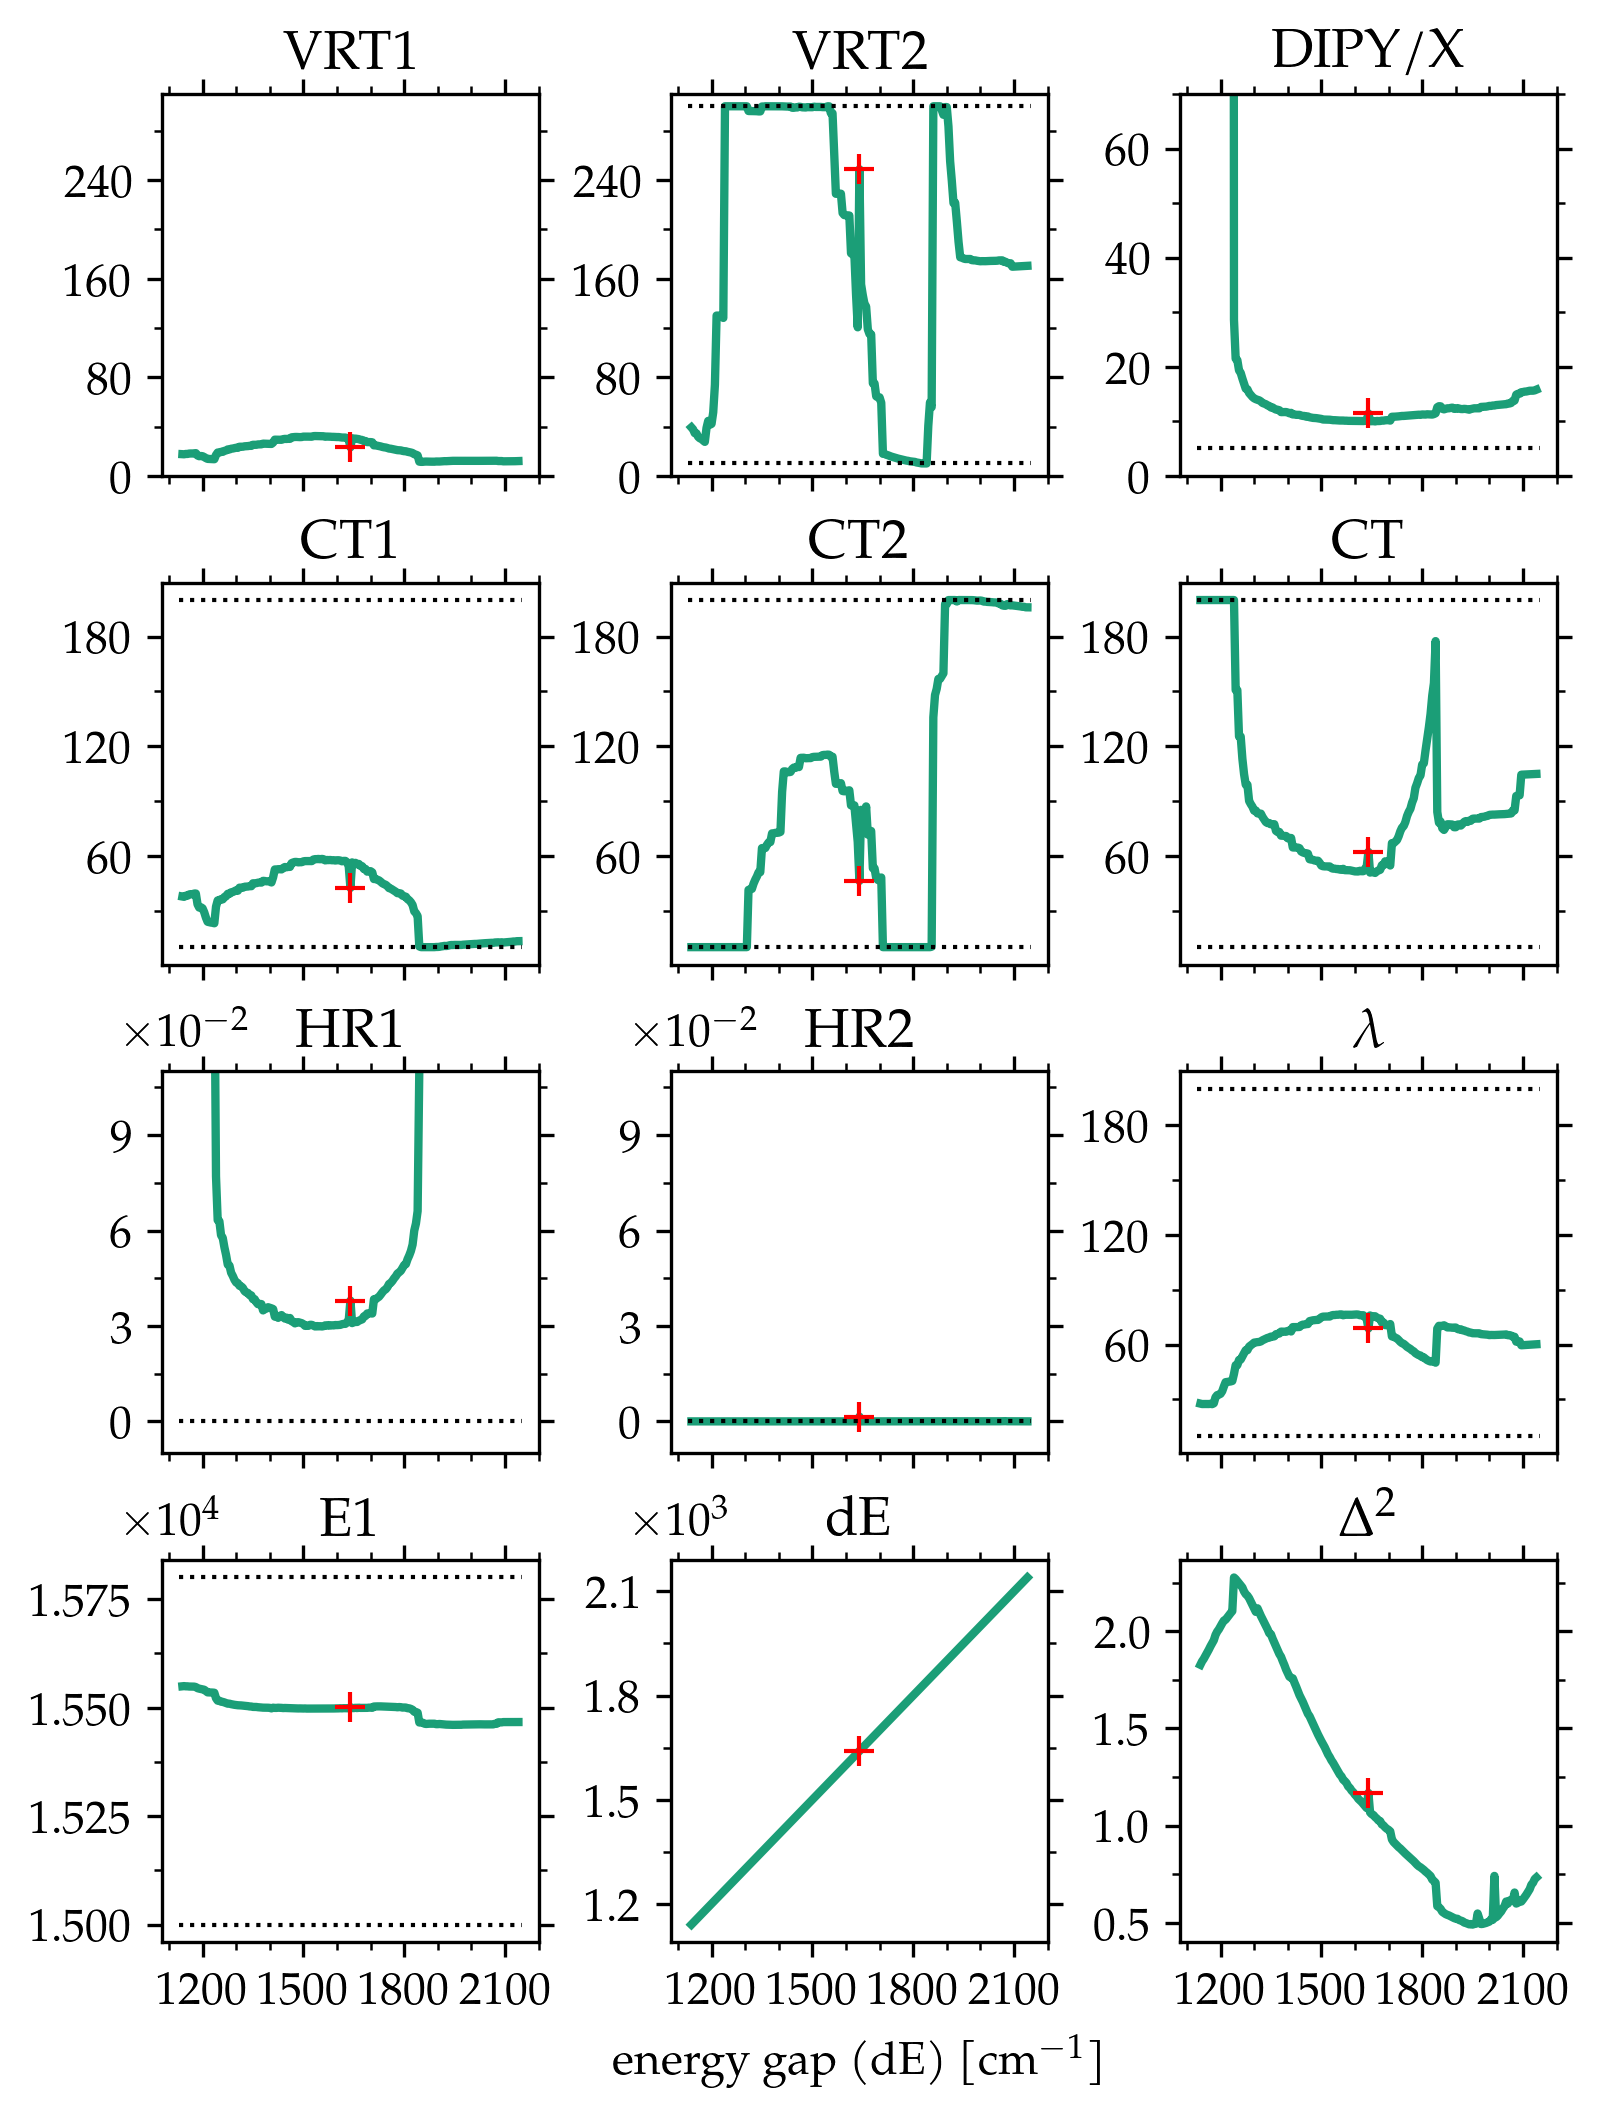

In [8]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[lim0:lim1]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == ivalue][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

# ## omega
# grid[3,1].plot(labels, om1, **pars)
# grid[3,1].plot(labels[ii], om1[ii], **mpars)
# grid[3,1].set_title('OM1')
# #draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

## dE
grid[3,1].plot(labels, de, **pars)
grid[3,1].plot(labels[ii], de[ii], **mpars)
grid[3,1].set_title('dE')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    

grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

#grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.11)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

#grid[0,0].set_xlim(10, 80)
grid[0,2].set_ylim(0,70)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(300))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(100))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('energy gap (dE) [cm$^{-1}$]')